# Oldschool Stats using normal approximations

We'll start with some simple probability examples and work our way up to z-tests and t-tests (A/B testing). This is the **Oldschool Notebook**. I have a second notebook that does all of this again, using simulations which may be more intuitive to some people and is more modern and flexible in many ways. The latter is heavily inspired by *The Foundations of Statistics - A Simulation-based Approach* by Shravan Vasishth and Michael Broe.

Before we begin, here are a few definitions of terms that we'll be using throughout the notebook:

**Population**: the set of all individuals/items of interest  
**Sample**: a set of individuals/items selected from the population

**Parameter**: a value that describes a population property (e.g. $\mu, \sigma$). Fixed. Usually unknown.  
**Statistic**: a value that describes a sample property (e.g. $\bar{X}, s$). Want to pick statistics that allow us to estimate parameters.

We often try to estimate the properties of the population (parameters) from the properties of our observed sample (stastic). An **estimator** is a process that generates such an estimate. An example of such estimators could be the sample mean and variance. Estimators can be biased (on average, produces and estimate that is higher or lower than the population parameter) or unbiased. 

**Sample Distribution**: A distribution of observed scores measured from one sample of individuals  
**Sampling Distribution**: A distribution of *all posible values of a sample statistic* (from all possible samples of size n)

## Binomial Distribution

Suppose you observe the following sequence of coin flips:

H H T H T T H H H H

That's 7 heads and 3 tails. Are you willing to make a bet on the next coin flip? Do you think this is a fair coin? That is, is P(H) = P(T) = 0.5? Or something else? What if the sequence contained 8 heads and 2 tails? What if it had 10 heads and no tails? What number of heads would you need to see in a series of 10 flips before you said something was fishy? What if the number of flips was different? Let's say 7/10 seems odd, what about 70/100? That's the same proportion, but does one seem more likely than another given a fair coin? What if you only had two flips both were heads? Fair coin or totally biased toward heads?

In this notebook, we're going to tackle these questions with an "exact" approach. This is a very oldschool way of doing it which works because we happen to know the binomial function (and other distributions which we will use later). In the newschool notebook, we can see how we can get at these things using sampling without having to know or make any assumptions about the population distribution. This will be related to bootstrapping. 

In [323]:
# import some packages we will use
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, binom_test, norm, t as tdist, ttest_1samp
from scipy.special import comb
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

Let's start by computing the exact probability of getting 7 heads in 10 flips using the binomial theorem:

$\binom{N}{k} \cdot p^k(1-p)^{N-k}$

Let's write a function that will do this calculation for us:

In [2]:
def binomProb(k,n,p):
    '''
    Returns the probability of getting k successes in n trials with probability p
    
    aka binomial probability mass P(X = k)
    '''
    return comb(n,k)*p**k*(1-p)**(n-k) # comb is from scipy.special

In [3]:
#Let's try this out for 7 heads:
binomProb(7,10,0.5)

0.1171875

And now let's make a plot of this for all possible numbers of heads out of 10 flips. This is the probability mass function.

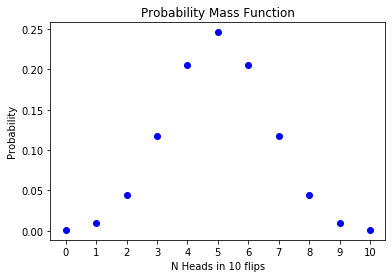

In [11]:
n = 10
p = 0.5
x = np.arange(0,11)
y = binomProb(x,n,p)
plt.plot(x,y,'bo')
plt.xlabel('N Heads in 10 flips')
plt.ylabel('Probability')
plt.xticks(x)
_ = plt.title('Probability Mass Function')

From the calculation above (and the graph) we can see that the probability of getting exactly 7 heads out of 10 flips is 11.7%. Are we willing to say that the coin is biased if we observe this? Maybe, maybe not. We'll come back to making decisions from probabilities later.

For now, let's note that 7 heads isn't the only extreme value that we might observe: 8, 9, or 10 heads would be equally surprising if the coin was actually fair. This is the probability that we get *at least* 7 heads: $P(X \geq 7)$ (given 10 flips)

Getting at least 7 heads --> either you get 7 or 8 or 9 or 10  
$P(X \geq 7) = P(X=7)+P(X=8)+P(X=9)+P(X=10)$

In [15]:
np.sum(binomProb(np.array([7,8,9,10]),10,0.5))

0.171875

So there's a 17% chance that, if the coin is actually unbiased, I will end up with at least 7 heads.

Note that this is just the sum of the heights of the points in the first graph. That is just how we compute the cumualtive distribution function (CDF):

### Cumulative Distribution Function

CDF of a random variable X at x is the probability that X takes on a value less than or equal to x: $F(x) = P(X\leq x)$ For a discrete random variable, it can be computed by summing up all of the points up to and including x:

In [50]:
def binomCDF(x,n,p):
    '''
    Cumulative Distribution Function for the binomial distribution.
    
    Computed by summing over the mass function
    '''
    return np.sum(binomProb(np.arange(0,x+1),n,p))

# Note that both of these functions exist in the scipy stats package: scipy.stats.binom.pmf binom.cdf

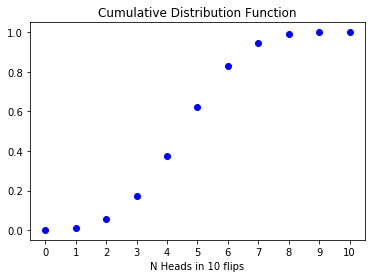

In [51]:
plt.plot(x,[binomCDF(xx,n,p) for xx in x],'bo')
plt.xlabel('N Heads in 10 flips')
plt.xticks(x)
_ = plt.title('Cumulative Distribution Function')

We can use the CDF to answer the question from before since $P(X \geq 7) = 1-P(X\leq 6)$: 

In [48]:
1-binomCDF(6,n,p)

0.171875

So one way we can interpet this is that there's a ~83% chance to get 6 or fewer heads (from CDF) and, conversely, there's a (1-0.83 = 0.17) 17% chance to get 7 or more heads. If the distribution was continuous instead of discrete, the CDF would correspond to the area under the first curve. We will return to this a little later.

We can go a bit further: sure, 7 heads may be unusual, but so is 3 heads! Perhaps what we want to know is "what's the probability of getting at least 7 heads *or* at least 7 tails?" We can compute in the same way as before:

In [52]:
np.sum(binomProb(np.array([0,1,2,3,7,8,9,10]),10,0.5))

0.34375

This is just double what we had before because the pmf is symmetric.

## Binomial test and p-value

What we just did is called a *binomial test*. It computes the exact probability of observing at least k of the same type of outcome (k heads or k tails). This is a **two-tailed** test because we are looking at both tails of our probability distribution for "extreme values". If we were just interested in the probability of 7 or more heads (but didn't care about 7 or more tails), this would be a **one-tailed** test because we would just be looking at one tail of the distribution. More on this later. 

There is a built-in function that will do the calculation for us that we did by hand above:

In [61]:
binom_test(7, n=10, p=0.5)

0.3437499999999999

The output of the binomial test is a **p-value**! In this case, it is the probability of observing at least 7 or more heads, or 7 or more tails *given that the coin is unbiased (p=0.5)*. We would read it as "there is a 34.37% chance of observering at least 7 heads or tails if the coin was unbiased". 

In general, we will define the p-value as the probability of observing a value at least as extreme as what was was observed given some statistical model.

IMPORTANT NOTE: in this context only, p is used to refer to the probability of a head, *not* to the p-value. When you are reading stuff online and see things like p<0.05, that p usually refers to the p-value. Sorry for the confusion in this example.

Why the emphasis on p=0.5 (unbiased coin) in describing the p-value? Consider what would happen if instead the coin was very biased so that p=0.8. Now 7 heads out of 10 flips doesn't seem so unusual. So our interpretation of the p-value is relative to some model or assumption or hypothesis. We are asking "how likely is it that the sample we observed came from a population with some particular set of parameters (p=0.5)." This hypothesis about the parameters is called the **Null Hypothesis**.

In this case, we define the null hypothesis as:  
$H_{0}: p = 0.5$

We typically contrast this with an alternative hypothesis:  
$H_{A1}: p \neq 0.5$  
This means that the probability of generating a head is greater than or less than 0.5

We could be more specific and have a hypothesis like:  
$H_{A2}: p > 0.5$  
This would mean that we expect the probability of generating a head to be more than 0.5

These hypotheses are about the *parameter (aka population statistic) p*. A **hypothesis test** is a statistical method that uses sample data to evaluate a hypothesis about about a population. In this case, our sample is the observation of 7 heads in 10 flips which we will use to evaluate the hypothesis that the coin is fair (p=0.5). 

Note that all of our discussion above was under the assumption of $H_{0}$. If the null hypothesis were true, how likely was it that we observed at least 7 heads ($H_{A2}$)? ~17%. At least 8 heads? ~5%. Maybe that's unlikely enough (i.e. low enough) for us to warrant *rejecting the null hypothesis*. This means that we believe that it is not very likely that our sample (7 heads out of 10) came from a fair coin (a process/model with p=0.5). Rejecting the null hypothesis says that our sample is not compatible with this model. Note that we *do not accept the alternative hypothesis*. All that we can say is that our observation is unlikely *under the null hypothesis*. The p-value is not a measure of how true a hypothesis it; it is a measure of how likely our sample is given a hypothesis. This also does not mean that the null hypothesis is false! Even with a fair coin, you can expect to get at least 8 heads 5% of the time. In our sample with 7 heads, for a fair coin, we expect to get this result 17% of the time. If we decide that 17% is too high of a chance to risk saying that the coin is biased, then we are said to *fail to reject the null hypothesis*. However, just because we failed to reject does not mean that the null hypothesis is true! Perhaps we got a biased sample, or don't have enough data, etc. In general, a lack of an effect in a sample is not good evidence for lack of evidence in a population. "Absence of evidence is not evidence of absence."

#### Inverse CDF

Where we decide to place the cut-off is called the **critical value** and the probability associated with that critical value is called **alpha**. In this case, I arbitrarily set alpha at 5% which corresponds to a critical value of 8 heads (i.e., the place on the distribution where 5% of the mass is to the right of the critical value). I got this from eyeballing the graph, but is there a way to determine this more rigorously? What I want to know is, what is the # of heads I need to get that I would expect to get by chance only 5% of the time? For this we'll need the inverse of the cumulative distribution function. I like to think of it in this slightly hand-wavy way: the CDF let's me go from a particular x value to the mass (or area under the curve for a continuous distribution) up to that value (e.g., for 8, this is the sum of all of the probabilities from X=0 up to X=8 (or from -inf to x for a continuous distribution)). The inverse CDF let's me go the other way: given a particular mass or area under the curve (say 100-5=95%), what's the position on the x-axis that has that much mass to the left of it? That is, before, we used an equation to go from $P(X \leq x)$ to a probability; the inverse CDF allows me to go the other way: given a probability, what's the corresponding x? I'm going to use a built-in function for the inverse CDF of a binomial:

In [225]:
binom.ppf(0.95,10,0.5)

8.0

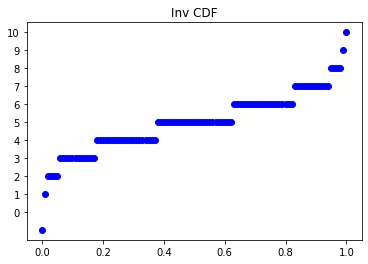

In [60]:
# we can plot the entire inverse CDF function:
xp = np.arange(0,1.1,0.01)
plt.plot(xp,binom.ppf(xp,10,0.5),'bo')
plt.yticks(x)
_ = plt.title('Inv CDF')

To read this graph, we would go off the x-axis: 95% of the pmf is to the left of the 8 heads. 75% of the pmf is to the left of 6 heads. etc. All we've really done is just turned the CDF graph on its side. It look a little funny because we have a discrete distribution. For a continuous distribution, this would be smooth. (Note that the point on the far left that's -1 should just be 0.)

#### Back to hypothesis tests

$H_{A2}$ specifies a **one-tailed** threshold in that I am only looking at the area under the curve (the **critical region**) to the right of the critical value. In contrast, $H_{A1}$ is **two-tailed**: I consider extreme values those when the number of heads is really high *and* really low. If I still use an alpha of 5%, I'll split it up into two equal sized areas of 2.5%, one on the right side of the distribution and one on the left. Looking at the graph, 9 or more heads is about 1.5% of the area, but if I include 8 heads then I'm up to 5%, so, because this distribution is discrete, I'll set my threshold at 9 heads. Now, 2.5% (actually 1.5%, but we can't have 8.6 heads) of the distribution is to the right of 9 (inclusive) and 2.5% is ot the left of 1 head (inclusive). So I will reject the null hypothesis (that p=0.5) if I observe 0, 1, 9, or 10 heads and I should expect to observe that number of heads approximately 5% of the time by chance. 

To reiterate: 5% is the alpha value and I split it between the two tails of the distribution. I use it  to determine the critical value (1 head and 9 heads) using the inverse CDF and this can tell me how extreme of an observation I need to reject the null hypothesis. In psychology, an alpha value of 5% or 1% is usually used. In physics, it's 3 x 10^-7 or 5-sigma (we'll get to sigma later). 

The alpha value is the probability of a **Type I error** (incorrectly rejecting the null hypothesis) given that the null hypothesis is true.

What is the right alpha value to use? It depends. How costly is it to incorrectly say that a coin is biased when it really isn't? How costly is it to say that a drug has a positive effect when it doesn't? That a neutrino is detected?

Should you use a one-tailed or a two-tailed test? Notice that for a two-tailed test, I need to observe at least 9 heads to rejects the null hypothesis, but for the one-tailed test, only at least 8. Does that mean it's a more powerful test? No! You should have a very good *a priori* reason for why to you would be using a one-tailed test (i.e., why you're alternative hypothesis is directional). If I'm testing a drug, should I assume that it only has a benefit relative to baseline/placebo? Or can it cause a decrease in my measure? In most of the A/B testing that we'll be talking about later, we'll probably be using two-tailed tests.

Summary:

**p-value**: probablity of observing a value as or more extreme than a given value given some model  
**alpha value**: the probability value that we use to determine which sample outcomes are considered very unlikely if the null hypothesis is true  
**critical region**: the region of the sampling distribution that contains the sample outcomes that are considered very unlikely if the null hypothesis is true  
**critical value**: the value(s) that define the boundaries of the critical region(s)  
**Type I error**: Probability of rejecting the null hypothesis when it is true: $P(\text{Type I error} | H_{0}) = \alpha$

As an aside, we can also discuss what the "best" estimate of the population parameter would be given that we only observed our sample. I won't go through the details here, but an unbiased estimator of p, the population parameter, is $\hat{p} = \frac{\sum{x_i}}{n}$, that is, the best estimate of p is the proportion of heads we observe: 0.7. We can get to this via maximum likelihood estimation (MLE) without actually doing the math: let's look at all the possible ways we could have gotten 7 heads in 10 samples (i.e., all the possible coins/biases we could have had):

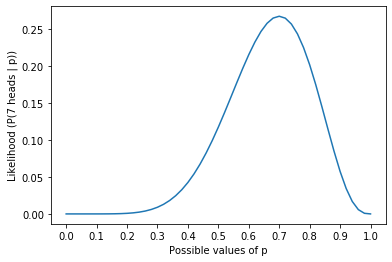

In [69]:
plt.plot(np.arange(0,1.02,0.02),binomProb(7,10,np.arange(0,1.02,0.02)))
plt.xlabel('Possible values of p')
plt.ylabel('Likelihood (P(7 heads | p))')
_ = plt.xticks(np.arange(0,1.1,0.1))

Here, I selected different possible values of p, and plot, for each value, what the probability would be of getting 7 heads. You can see that when p=0.5, the height of the distribution is around 11% -- this is the value we saw before in our pmf. The peak of the distribution is at 0.7: the most likely coin to generate 7 heads in 10 flips is one that has a bias to come up heads 70% of the time.

# Z-stats (for a single proportion)

What if n or k are large? In the olden days, it was difficult to compute by hand the factorials in the binomial formula so the normal distribution was created to approximate the binomial. They have very similar shapes, especially as n gets large. 

Just like we needed n and p to specify the position and shape of the binomial distribution, we'll also need some parameters for the normal distribution: the mean (mu) and standard deviation (sigma). We want the normal that we use to approximate the binomial to have the same mean and standard deviation as the binomial and we'll use the known formulas to compute those (if interested, can derive separately):

In [195]:
# Here I am using lambda functions to make one-liners that let me compute the mean and sd of a binomial
# distribution. Can also use built-in: scipy.stats.binom.mean(n,p) and binom.std(n,p)
mu_bin = lambda n,p : n*p
sigma_bin = lambda n,p : np.sqrt(n*p*(1-p))

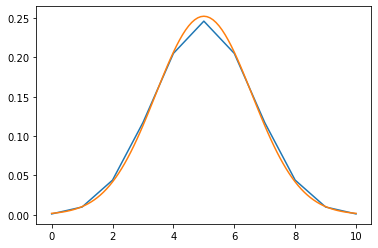

In [196]:
# we'll use a built-in function to get the pdf of the normal distribution and plot it (orange) on top of
# the pmf for the binomial (blue). The loc and scale parameters specify mean and sd
plt.plot(np.arange(0,11),binom.pmf(np.arange(0,11),10,0.5))
_ = plt.plot(np.arange(0,10.1,0.1),norm.pdf(np.arange(0,10.1,0.1),loc=mu_bin(n,p), scale=sigma_bin(n,p)))

We can see that the two distributions are pretty darn similar! Ok, so let's do the same thing we did before, but now for a much bigger n, say, 100 flips instead of 10:

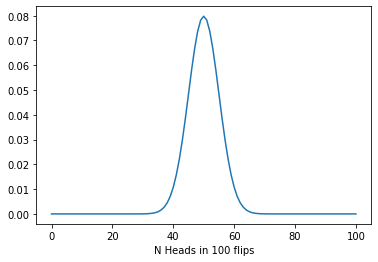

In [227]:
n = 100
plt.plot(np.arange(101),norm.pdf(np.arange(101),loc=mu_bin(n,p),scale=sigma_bin(n,p)))
_ = plt.xlabel('N Heads in 100 flips')

Now we want to answer similar questions like: how likely are, say, at least 65 heads out of 100? Well we could do the same thing that we did before and add up all of the probabilities for getting 0, 1, 2, ... 65 heads. But that's tedious and will get increasingly difficult as we increase the number of heads or start considering continuous distributions where we need to integrate instead of taking the sum. Fortunately, someone has gone ahead and computed all of these values for us for the **standard normal distribution** (aka z-distribution aka Gaussian) which has a mean of 0 and a std of 1. The pdf and cdf of a standard normal are listed "z-tables". In order to use this table, we'll need to perform a **linear transformation** of our data. A linear transformation of data preserves the relative position while changing the center and scale of the distribution. 

From some basic rules about normal distributions:  
If $X \sim N(m,s^2)$  
then  
$X+c \sim N(m+c,s^2)$  
$X*c \sim N(m*c, s^2*c^2)$  

If I start with X, subtract m and divide by s, then:  
$X-m \sim N(m-m,s^2)$ -->  $X-m \sim N(0,s^2)$  
$(X-m)/s \sim N(0,s^2 * 1/s^2)$   --> $(X-m)/s \sim N(0,1)$ 

So by taking a normal distribution, subtracting the mean and dividing by the standard deviation, I can convert it into a standard normal. I can then use my z-table to do all of the fun things I did before like find the area to the left or to the right of some value or find the critical value for which some percentage of the distribution is to the left/right. These are well known for the standard normal: approximately 64% of the area falls between $\pm 1 \sigma$, 95% between $\pm 2 \sigma$, and 99.7% between $\pm 3 \sigma$.

For a given observation (say 65 heads), we can convert it to a **z-score** -- a normalized score -- and then do all of our fun computations and tests. z-scoring has several advantages: for different variables with different scales, we can transform them to all have the same scale so we can compare different distributions. For example, is 3 inches above the average height an extreme or small deviation? That's hard to say just from the raw numbers. But if you know that 3 inches is actually 4 standard deviations above the mean, then this is much more informative. Z-scores are "distribution-free" units. 

The general formula is:  
$z_i = \frac{x_i - \mu}{\sigma}$

In [228]:
# Let's try it for our value of 65 heads out of 100:
mu = mu_bin(n,p)
sigma = sigma_bin(n,p)
z = (65-mu)/sigma
print(z)

3.0


We can see where 65 and 3 fall on the original and the standardized distributions:

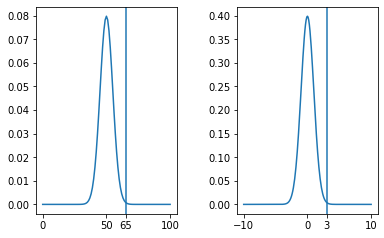

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=3)

ax1.plot(np.arange(101),norm.pdf(np.arange(101),loc=mu_bin(n,p),scale=sigma_bin(n,p)))
ax1.axvline(65)
ax1.set_xticks([0,50,65,100])
ax2.plot(np.arange(-10,10.1,0.1),norm.pdf(np.arange(-10,10.1,0.1)))
ax2.axvline(3)
_ = ax2.set_xticks([-10,0,3,10])

You can see that although the distributions are centered and scaled differently, the relative position of the line on the left at 65 and the line on the right at 3 are identical. 

# One proportion Z-test

Again, the advantage is that now we can use our handy-dandy z-table (or a built-in function, thanks computers!) to compute the the probability of observing at least 65 heads out of 100 flips:

In [268]:
# on the raw value x:
1-norm.cdf(65,loc=mu,scale=sigma)

0.0013498980316301035

In [243]:
# on the z-scored value:
1-norm.cdf(3)

0.0013498980316301035

Congratulations, you just performed a **one-proportion z-test**! (We were expressing our data in terms of absolute number of heads, but could just as easily have written it as 65/100.) The above value is again a p-value, just like for the binomial test. It says that there is a 0.13% chance of observing 65 heads or more by chance *under the null hypothesis that the coin is fair!* (p=0.5, or alternatively, that the proportion of heads, $p_0$ is 0.5. I use this $p_0$ notation to connect it to a point I will make below). There are a few very important things to note:  
(1) *We had to know the mean and standard deviation of the population distribution*. Recall how we ended up with our pretty graphs: we had a formula that allowed us to compute how often we can expect to get k heads out of n flips. The normal distribution is an approximation of this, but it is still a distribution for which we know the function and which we can evaluate for every k. This is what allows us to say whether a particular sample (65 heads) is unusual or not: we know how likely all of the other samples would be (for which we only need the mean, std, and function).  
(2) We assume that the population distribution is normal! If we have reason to believe that it is highly skewed or multimodal or anything else, a z-test would not be appropriate.

The function proportions_ztest in the statsmodels package can do this test for you without having to compute everything.

What if we wanted to know the number of heads that would correspond to an alpha of 0.05 (5% chance of falsely rejecting the null hypothesis, which is still that p=0.5)? We would use the inverse CDF! (on a z-table, or on our computer): 

In [248]:
# in standard deviation units
norm.ppf(0.95)

1.6448536269514722

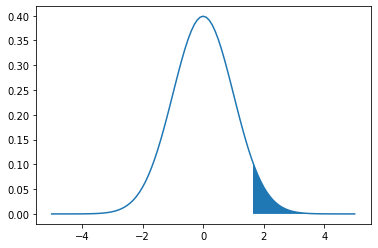

In [355]:
#which corresponds to this point on the curve where the area to the left of it is 95% of the total area:
plt.plot(np.arange(-5,5.1,0.1),norm.pdf(np.arange(-5,5.1,0.1)))
_ = plt.fill_between(np.arange(norm.ppf(0.95),5.1,0.1),norm.pdf(np.arange(norm.ppf(0.95),5.1,0.1)))
# that is the critical region

In [249]:
# which we can convert back to our original x scale by inverting the formula for z:
norm.ppf(0.95) * sigma + mu

58.22426813475736

In [250]:
# or directly:
norm.ppf(0.95,loc=mu,scale=sigma)

58.22426813475736

Note that because the normal distribution is continuous while the binomial was discrete, we end up with fractional numbers of heads and should probably round this.

This number says that ~5% of the time, when flipping a fair coin, just by chance, we expect to get at 58 heads or more.

It should be noted that when you look up "z-test for a proportion" you'll get what looks like a different equation for converting x to z:  
$z = \frac{\hat{p}-p_0}{\sqrt{\frac{p_0 * (1-p_0)}{n}}}$  
However, this is actually the same formula as we used! If we had taken a further step of dividing x by n to get a proportion, then  
$std(X/n)=s/n$ where s is the standard deviation of X  
this is just for the same reason as above: $X*c \sim N(m*c,s^2*c^2)$ and c = 1/n  
and since $s=\sqrt{n*p*(1-p)}$ then  

$s/n=\frac{\sqrt{n*p*(1-p)}}{n}=\sqrt{\frac{n*p*(1-p)}{n^2}}=\sqrt{\frac{p*(1-p)}{n}}$

I don't like that this formula is shown as somehow a different way of z-scoring our data. This is confusing. It's actually the exact same thing that we were doing above: we are always subtracting a mean (in this case of the population) from our observed value (7/10 heads) and dividing by the standard deviation (again, of the population).

We can doublecheck everything by actually running the binomial test and comparing to the approximation using the normal distribution:

In [271]:
1-norm.cdf(65,loc=mu,scale=sigma)

0.0013498980316301035

In [272]:
binom_test(65,100,0.5,'greater')

0.0017588208614850807

In [273]:
# this isn't quite the same because the binomial distribution is discrete, but the normal is continuous.
# if we want a better comparison, we should probably split the 65 bin in half:
1-norm.cdf(64.5,loc=mu,scale=sigma)

0.001865813300384045

In [274]:
# we can test this out for other #s of heads:
binom_test(54,100,0.5,'greater')

0.2420592068036454

In [275]:
1-norm.cdf(53.5,loc=mu,scale=sigma)

0.24196365222307303

The normal distribution is just an approximation, so it's not perfect, but it's pretty close.

So, to summarize, the z-score is the number of standard deviation units that the observation is away from the population mean. We set a threshold (critical value) to decide whether this observation is extreme enough to warrant saying that it was unlikely to have come from this distribution (with its specific parameters). If the p-value, the probability of observing this or more extreme of a value, exceeds the threshold, we deem it unlikely that the value came from this population (reject the null hypothesis). 

# Sampling Distributions

Let's consider another kind of dataset. Suppose we've got a class of 48 students with an average IQ of 115. Is this class particularly gifted? IQ scores are normalized to have a mean of 100 and a standard deviation of 15 in the population. What we are essentially asking is: Do these 48 students come from the same population or from a different population?

To begin addressing this question, we need to distinguish between properties of the population and of the sample:  
$\mu$: the mean of the population distribution  
$\sigma$: the standard deviation of the population distribution    
$\bar{X}$: the sample mean  
$s$: the sample standard deviation

Just like 10 flips of a coin might come out many different ways, sampling 48 people from our population might end up with many different sets of IQs. Each sample will have its own mean and standard deviation (sample statistics). We refer to all possible such sample means as the **sampling distribution** of the sample means. There will likewise be a sampling distribution of sample standard deviations and all other sample statistics. In practice, we can't actually take every single sample, but we can model it! 

Let's add two new terms:  
$\mu_{\bar{X}}$: the mean of the sampling distribution of means  
$\sigma_{\bar{X}}$: the std of the sampling distribution of means

## Central Limit Theorem

The central limit theorem says that the distribution of the sum of a large number of independent and identically distributed (i.i.d) random variables approaches a normal distribution. 

The mean is a normalized sum (add up all the $x_i$s and divide by n), so the distribution of means (i.e. the sampling distribution) will approach a normal distribution (if n is large or if the population distribution is normal).

In this case, we're dealing with IQ which is normally distributed, but the power of the CLT is that we can actually start with *any* population distribution and the sampling distribution of means will be normally distributed (if n is large enough). I'll leave the demonstration of this for the simulation notebook.

For now, we will just say that because of CLT:  
$\mu_{\bar{X}} = \mu$ -- the mean of the sampling distribution approximates the population mean  
$\sigma_{\bar{X}} = \frac{\sigma}{\sqrt{n}}$ -- as n increases, the standard deviation of the sampling distribution of sample means scales by a factor of the square root of n. We call the standard devation of the sampling distribution the **standard error**.

Note that the standard deviation of the sampling distribution depends on n! Intuitively: the larger of a sample we take, the more likely that the mean of that sample will be close to the population mean. In the limit, if we sample every single person in the population, then the sample mean will be exactly the population mean.

# One-sample z-test

Because the sampling distribution of means is normal and $\mu_{\bar{X}} = \mu$, we can ask: how unusual is our observed mean for our particular sample? Because we know the population mean $\mu$, we also know the mean of the sampling distribution of means. We can now do the same thing we did above: set some threshold for what we mean by "unusual" (our critical value) and ask if our observed mean exceeds this value: how many standard deviation units away from $\mu_{\bar{X}}$ is $\bar{X}$? Of all the possible means we could have gotten, how extreme is this one? (just like we were asking how extreme were 7/10 heads out of all possible #s of heads)

Again, we'll use our z-table for which we need to convert our sampling distribution, which is normal, into a standard normal:

$z = \frac{\bar{X_i}-\mu_{\bar{X}}}{\sigma_{\bar{X}}}$

Note the same general formula that we used above! Plugging in values for $\mu_{\bar{X}}$ and $\sigma_{\bar{X}}$ from above:

$z = \frac{\bar{X}-\mu}{\frac{\sigma}{\sqrt{n}}}$

In [277]:
# for our example: 
mu = 100
sigma = 15
n = 48
x_bar = 115

z = (x_bar-mu)/(sigma/np.sqrt(n))
print(z)

6.928203230275509


Our particular sample of students is 7 standard deviations away from the mean IQ! It's very unlikely that they would have come from the same population. The value we computed is again the **z-statistic** and the test we just performed is the **one-sample z-test**. It required knowing the population mean and standard deviation because it was relative to the mean and variability in the population that we could assess the peculiarity of our sample. On average, we expect that, for large enough samples, their mean should be close to the population mean of 100. The z-test tells us that we've got an unusual sample here. We are *rejecting the null hypothesis* that the sample came from a population with mean 100, i.e. $H_0: \mu = 100$

I'm going to skip the two-sample z-test in the interest of time. It will be similar to the two-sample t-test below.

# One-sample t-test

In practice, we rarely know the properties of the population. Nor do we have the luxury of drawing many samples. Instead, we might have just our one sample and want to ask questions about the population based on this sample. For example, we might want to know if the average height of the people in our group similar to the average height of people in the US which is ~168cm (averaged across men and women). Usually, t-tests are used when n<=30 and the sample distribution is approximately normal. Let's suppose we have the following data for our group:

[171.60866799 162.54384014 164.49957161 170.03105608 163.67158185
 166.82909185 164.99625584 162.04529387 159.94532967 160.37842578
 161.40620753 163.88522075 173.97172545 153.26348699]


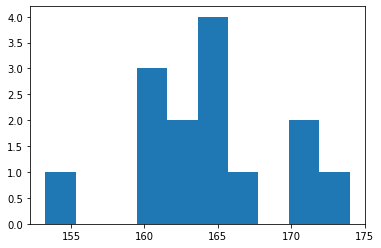

In [312]:
heights = norm.rvs(164,scale=4,size=14)
print(heights)
_ = plt.hist(heights)

Our null hypothesis is that the population mean is 168 cm:  
$H_0: \mu = 168$  
The alternative hypothesis is that the population mean is something else:  
$H_A: \mu \neq 168$

Or we can say: we want to know how likely it is that our particular sample of 14 came from a distribution with a mean of 168. 

Unlike the previous example, we don't know the standard deviation of heights in the population so we don't know the standard deviation of the sampling distribution, so let's estimate it with... $\frac{s}{\sqrt{n}}$  That's right. We don't know the true standard deviation of the population so let's just guess that it's the same as the standard deviation of our sample. using that, we can estimate the standard deviation of the sampling distribution (standard error) and we will use this to form a new statistic, the **t-statistic**:

$t = \frac{\bar{X_i}-\mu_{\bar{X}}}{s_{\bar{X}}}$

$t = \frac{\bar{X}-\mu}{\frac{s}{\sqrt{n}}}$

The logic of this test is exactly the same as before -- we're taking some value and asking how far away from the mean is it in terms of standard deviation units. In this case, we use a different distribution, the t-distribution (for which we also have a t-table of values) which looks very similar to the normal distribution, but has fatter tails. This represents the greater uncertainty we have in the population standard deviation which we were estimating and therefore in the possible distribution of sample means in the sampling distribution. The shape of the t-distribution depends on n (and we have separate t-tables for each value of n). As n increases, the t-distribution approximates the normal distribution. 

In [325]:
# so for the above example:
m = np.mean(heights)
s = np.std(heights,ddof=1) # ddof is to indicate that we're dividing by n-1 for the sample standard deviation
n = len(heights)
t = (m-168)/(s/np.sqrt(n))
print(m,s,n,t)

164.21969681386355 5.261542854331012 14 -2.688298799849071


The negative value indicates that our sample mean is to the left of the population mean. We will have to look this up in a t-table or use a function that will tell us how unlikely this observation is:

In [328]:
tdist.cdf(t,df=n-1)

0.009302178019820298

The output here is again the p-value: it is the probability of observing a sample mean of 164 or less given that the population mean was 168 (the null hypothesis). This is a one-tailed value. If we wanted to know the probability of the sample mean being less than or equal to -2.69 *or* greater than or equal to 2.69, we would just double this value.

The degrees of freedom (df) is the number of observations in the sample - 1. We can think of it as the number of pieces of independent information that go into a calculation. Each observation is such an independent piece of information that goes into determining the sample mean. There are many possible combinations of observations that, when averaged together, produce the same result. However, if you know what n-1 of those observations and you know what the mean is supposed to be, there can only be one value for the nth observation. Hence the degrees of freedom is n-1. 

If we had set a 95% threshold (alpha=0.05), then the critical values would be:

In [338]:
[tdist.ppf(0.025,df=13)*(s/np.sqrt(n))+168, tdist.ppf(1-0.025,df=13)*(s/np.sqrt(n))+168]

[164.96207560122878, 171.03792439877122]

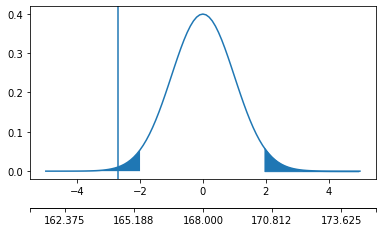

In [385]:
#graphically:
fig = plt.figure()
ax1 = fig.add_axes((0.1,0.3,0.8,0.6)) 
ax1.plot(np.arange(-5,5.1,0.1),norm.pdf(np.arange(-5,5.1,0.1)))
ax1.fill_between(np.arange(-5,norm.ppf(0.025),0.05),norm.pdf(np.arange(-5,norm.ppf(0.025),0.05)))
ax1.fill_between(np.arange(norm.ppf(1-0.025),5,0.05),norm.pdf(np.arange(norm.ppf(1-0.025),5,0.05)),color='C0')
ax1.axvline(t)
ax2 = fig.add_axes((0.1,0.2,0.8,0.0))
ax2.yaxis.set_visible(False)

new_tick_locations = np.array([-5,-4,-2,0,2,4,5])

def tick_function(X):
    V = X*(s/np.sqrt(n))+168
    return ["%.3f" % z for z in V]

ax2.set_xticks(new_tick_locations)
labs = tick_function(new_tick_locations)
labs[0] =''
labs[-1] = ''
_ = ax2.set_xticklabels(labs)
# couldn't get the second axis labels to line up nicely... they are supposed to be diretly underneath the above labels

Because the observed sample mean falls within the critical region (outside of the range above), we reject the null hypothesis that our group is of average height for the US population.

In [324]:
# we can get the t-stat and p-value using a built-in scipy function:
ttest_1samp(heights,168)

Ttest_1sampResult(statistic=-2.688298799849071, pvalue=0.018604356039640595)

Note that the p-value reported here is double the p-value above because it is a two-tailed test.

# Two-sample t-test (A/B testing)

## Dependent / Paired-sample t-test

Suppose I have a group of students who take a test once, and then take a Magic Test Pill (TM) that is supposed to help them focus and take the test again. I want to know: has the pill changed the average test score? Or, is the average score of all people (from whom I've only gotten a sample) who take the test without the pill ($\mu1$) the same as the average score of all the same set of people after taking the pill ($\mu2$)? Or, is the difference between the scores before and after the pill 0 or different from 0?

$H_0 : \mu_1=\mu_2$ or $ \mu_2-\mu_1=0$ (just rearranging the terms in the equation)

Now we've got *two* samples, one from before the pill and one from after. We want to know if the two population distributions from which these samples are drawn are actually one distribution or two different ones. 

Our hypothesis says that the means of the two distributions should be the same, or the difference between the means should be 0. Again, we don't know the population mean(s), but we do know that the sampling distribution of the means of pre- and post-pill scores ($\bar{X_1}$ and $\bar{X_2}$) should be good estimates of those means. Instead of looking at these values directly, let's look at the *difference scores*, that is, the difference between post-pill and pre-pill performance. We'll call the distribution of differences $X_D$. What are the properties of the sampling distribution of differences?

If we have two normally distributed random variables X and Y where $X \sim N(m_1,s_1^2)$ and $Y \sim N(m_2,s_2^2)$ then  
$X+Y \sim N(m_1+m_2,s_1^2+s_1^2)$  
and  
$X-Y \sim N(m_1-m_2,s_1^2+s_1^2)$  
That is, the sum (or difference) of two normally distributed random variables is also normally distributed!

So since the sampling distributions of the pre- and post-pill groups are both normally distributed (because of CLT), so is the sampling distribution of differences of means! 

We can now proceed in the usual way by converting this sampling distribution of differences to a standard normal:

$t_{\bar{X_D}} = \frac{\bar{X_D}-\mu_D}{s_{\bar{X_D}}}$

What is $\mu_D$? That is precisely our hypothesis: $\mu_D = \mu2-\mu1=0$ and so

$t_{\bar{X_D}} = \frac{\bar{X_D}}{s_{\bar{X_D}}}$

So what we are really asking in our test is: is $\bar{X_D}$ different from 0? Just like before we were asking if some sample mean was different from some expected population mean (e.g. 168 cm). 

Our test statistic, $t_{\bar{X_D}}$ is the mean difference score divided by the estimated standard deviation of the mean difference score.

We'll approximate the standard deviation in the same way as before:

$s_{\bar{X_D}} = \frac{s_D}{\sqrt{n}}$

And our degress of freedom will again be n-1.

In summary: a paired aka dependent-samples t-test is the exact same idea as a one-sample t-test, except that instead of comparing the sample mean to a population mean, we are comparing a sample *difference* in scores to a population difference in scores (for which we estimate the standard deviation with the standard error). 

## Independent Samples t-test

What if instead of testing the same group twice (within group), we are interested in the difference *between* two groups? For example, perhaps we were concerned about practice effects (maybe people did better taking the test with the pill not because of the pill, but because it was their second time taking the test) so we wanted each person to only take the test once. In that case we'd need two groups: one group that took the test with the pill and one group that took the test without the pill. We then want to compare their mean scores and ask if there was a difference. Of course, what we're really asking is not "is there a difference between these two specific groups of people" -- if that's what we wanted to know, we'd just look at the exact means and say yes or no. What we really want to know is, is there a difference in the *population* means, i.e., if everyone in the world took the pill, would they do better than if they had not taken the pill? Our null hypothesis is the same as for the dependent samples test!

$H_0 : \mu_1=\mu_2$ or $ \mu_2-\mu_1=0$ 

and to be explicit about our null hypothesis:

$H_A : \mu_1\neq\mu_2$ or $ \mu_2-\mu_1\neq0$

We can write our equation in the exact same way:

$t = \frac{\text{sample mean difference}-\text{population mean difference}}{\text{estimated standard deviation of the mean difference}} = \frac{(\bar{X_1}-\bar{X_2})-(\mu_1-\mu_2)}{s_{(\bar{X_1}-\bar{X_2})}}$

And again, because the sampling distributions of the means are normally distributed, the difference will also be normally distributed so we can perform the same conversion and use our t-tables. (And we're using a t-statistic because we are estimating the standard deviation of the population.)

The degrees of freedom for the t-statistic is $(n_1-1) + (n_2-1) = n_1 + n_2 -2$

The tricky part comes in when it comes to computing $s_{(\bar{X_1}-\bar{X_2})}$. First, let's unpack what this is: for the sampling distribution of means of the two groups, the standard deviation of the distribution of means (the standard error) is $\sigma_{\bar{X_1}}$ and $\sigma_{\bar{X_2}}$ which is related to the standard error of the population:  
$\sigma_{\bar{X_1}} = \frac{\sigma_1}{\sqrt{n_1}}$  
$\sigma_{\bar{X_2}} = \frac{\sigma_2}{\sqrt{n_2}}$

Using our rules about the distribution of sums of normally distributed random variables, we know that the variance of the sum of two such variables is just the sum of their individual variances:  
$\sigma_{(\bar{X_1}-\bar{X_2})}^2 = \frac{\sigma_1^2}{n_1}+\frac{\sigma_2^2}{n_2}$  
or   
$\sigma_{(\bar{X_1}-\bar{X_2})} = \sqrt{\frac{\sigma_1^2}{n_1}+\frac{\sigma_2^2}{n_2}}$  
This is an expression for the true variance/standard deviation of the sampling distribution of the sample mean difference.

Note that if $\sigma_1=\sigma_2$ and $n_1=n_2$, then this simplifies to our normal equation $\sigma_{(\bar{X_1}-\bar{X_2})} = \frac{\sigma}{\sqrt{n}}$

As before, we don't have all of the possible samples so we don't know the true standard error. Instead, we estimate it:  
$s_{(\bar{X_1}-\bar{X_2})} = \sqrt{\frac{s_p^2}{n_1}+\frac{s_p^2}{n_2}}$

What's this funny $s_p^2$ term? Recall that the standard deviation of the sampling distribution (the standard error) depends on n: the larger n, the skinnier the distribution. We're also using the standard error as an estimate of the population standard devation (divided by $\sqrt{n}$)... so which one should be use if we've got samples with unequal sizes? The typical solution is to combine them into a kind of weighted average which we will call the **pooled standard deviation** (or the pooled estimate of the population standard deviation), usually expressed as the variance:

$s_p^2 = \frac{(n_1-1)s_1^2+(n_2-1)s_2^2}{(n_1-1)+(n_2-1)}$

Then 

$s_{(\bar{X_1}-\bar{X_2})} = \sqrt{\frac{s_p^2}{n_1}+\frac{s_p^2}{n_2}}$

If $n_1 = n_2$ this simplifies to the usual form. 

If we are not assuming equal variances for our two populations ($\sigma_1 \neq \sigma_2$) (or if it is not known if they are equal), then we do not pool the variances:

$s_{(\bar{X_1}-\bar{X_2})} = \sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}$

and add a correction to the degrees of freedom. This is called Welch's t-test. In scipy: stats.ttest_ind and set the optional argument equal_var to false. 

### t-test assumptions
- our scale of measurement is continuous and ordinal
- our sample is random (not biased)
- observations in the sample are independent (for a paired t-test, the pair differences should be independent)
- samples are independent (for an independent t-test)
- dependent measure is normally distributed in the population... but the tests are *robust* to the violation of this assumption (because of the CLT, even if the population is not normally distributed, the sampling distribution will be approximately normal).